In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt



=== Training with 10 bins per dimension ===
Episode 1/1000: Total Reward = -99683.00, Epsilon = 0.995
Episode 2/1000: Total Reward = -37131.00, Epsilon = 0.990
Episode 3/1000: Total Reward = -15292.00, Epsilon = 0.985
Episode 4/1000: Total Reward = -33402.00, Epsilon = 0.980
Episode 5/1000: Total Reward = -3654.00, Epsilon = 0.975
Episode 6/1000: Total Reward = -7203.00, Epsilon = 0.970
Episode 7/1000: Total Reward = -42033.00, Epsilon = 0.966
Episode 8/1000: Total Reward = -6436.00, Epsilon = 0.961
Episode 9/1000: Total Reward = -15452.00, Epsilon = 0.956
Episode 10/1000: Total Reward = -9016.00, Epsilon = 0.951
Episode 11/1000: Total Reward = -4813.00, Epsilon = 0.946
Episode 12/1000: Total Reward = -9091.00, Epsilon = 0.942
Episode 13/1000: Total Reward = -5971.00, Epsilon = 0.937
Episode 14/1000: Total Reward = -20684.00, Epsilon = 0.932
Episode 15/1000: Total Reward = -13698.00, Epsilon = 0.928
Episode 16/1000: Total Reward = -2193.00, Epsilon = 0.923
Episode 17/1000: Total Rewar

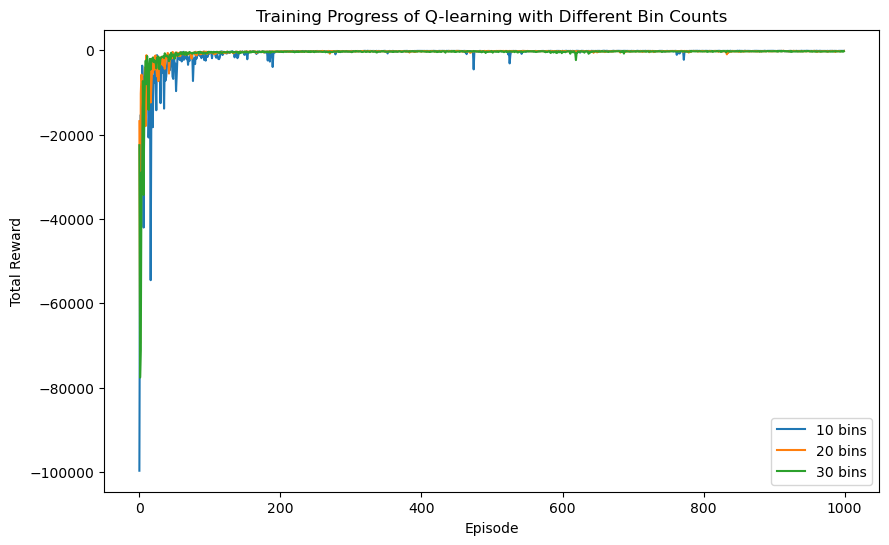


=== Summary of Results ===
Bins: 10, Final Average Reward (last 50 eps): -159.60
Bins: 20, Final Average Reward (last 50 eps): -231.58
Bins: 30, Final Average Reward (last 50 eps): -279.52

Best bin setting appears to be 10 bins based on final average reward.



2025-03-14 10:58:41.487 python[1315:18782] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-14 10:58:41.487 python[1315:18782] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Episode 1/1000: Total Reward = -8591.00, Epsilon = 0.995


KeyboardInterrupt: 

: 

In [ ]:
class UniformDiscretizer:
    def __init__(self, env, num_bins):
        self.env = env
        
        # Get the lower and upper bounds for each dimension in the observation space.
        self.obs_space_low = env.observation_space.low
        self.obs_space_high = env.observation_space.high
        
        # Convert num_bins to a numpy array if it's not already one.
        self.num_bins = np.array(num_bins)
        
        # Compute the width of each bin for each state dimension.
        self.bin_width = (self.obs_space_high - self.obs_space_low) / self.num_bins

    def discretize(self, obs):
        # Calculate bin indices by subtracting the lower bounds and dividing by the bin width.
        bin_indices = ((obs - self.obs_space_low) / self.bin_width).astype(int)
        
        # Ensure indices are within the valid range [0, num_bins-1] for each dimension.
        bin_indices = np.clip(bin_indices, 0, self.num_bins - 1)
        
        # Convert the array of indices to a tuple (useful for indexing a Q-table).
        return tuple(bin_indices)

def q_learning(env, discretizer, episodes=1000, alpha=0.1, gamma=0.99, epsilon=1, epsilon_min =0.05, decay_rate = 0.995):
    num_actions = env.action_space.n
    q_table = {}  # Q-values stored as: {state_tuple: np.array([q(a0), q(a1), ...])}
    episode_rewards = []

    def get_q(state):
        if state not in q_table:
            q_table[state] = np.zeros(num_actions)
        return q_table[state]
    #epilson = epsilon
    for episode in range(episodes):
        obs, _ = env.reset()
        state = discretizer.discretize(obs)
        total_reward = 0
        done = False

        while not done:
            # Epsilon-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(get_q(state))
            
            next_obs, reward, done, truncated, _ = env.step(action)
            next_state = discretizer.discretize(next_obs)
            total_reward += reward
            
            # Q-learning update: off-policy update using max_a' Q(s', a')
            best_next = np.max(get_q(next_state))
            get_q(state)[action] += alpha * (reward + gamma * best_next - get_q(state)[action])
            
            state = next_state
        epsilon = max(epsilon_min, epsilon * decay_rate)
        episode_rewards.append(total_reward)
        print(f"Episode {episode+1}/{episodes}: Total Reward = {total_reward:.2f}, Epsilon = {epsilon:.3f}")
    return q_table, episode_rewards

def run_optimal_policy(env, discretizer, q_table, episodes=5, render=True):
    """
    Run the optimal policy derived from the Q-table, rendering each step.
    """
    for episode in range(episodes):
        obs, _ = env.reset()
        state = discretizer.discretize(obs)
        done = False
        total_reward = 0
        print(f"\nRunning optimal policy - Episode {episode+1}")
        while not done:
            # Always choose the best action (greedy policy)
            action_values = q_table.get(state, np.zeros(env.action_space.n))
            action = np.argmax(action_values)
            
            # Render the environment
            if render:
                env.render()
            
            next_obs, reward, done, truncated, _ = env.step(action)
            total_reward += reward
            state = discretizer.discretize(next_obs)
        print(f"Episode {episode+1} finished with Total Reward: {total_reward}")
    env.close()


env = gym.make("MountainCar-v0")  
bin_values = [10, 20, 30]

diff_bin_rewards = {}
# <--- CHANGE: Loop over the bin values
for bins in bin_values:
    print(f"\n=== Training with {bins} bins per dimension ===")
    discretizer = UniformDiscretizer(env, bins)
    q_table, rewards = q_learning(env, discretizer, episodes=1000)
    diff_bin_rewards[bins] = rewards


plt.figure(figsize=(10, 6))
for bins, rewards in diff_bin_rewards.items():
    plt.plot(rewards, label=f"{bins} bins")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress of Q-learning with Different Bin Counts")
plt.legend()
plt.show()

# <-- CHANGE 4: Print out summary statistics (e.g., average reward in the last 50 episodes)
print("\n=== Summary of Results ===")
for bins, rewards in diff_bin_rewards.items():
    avg_last_50 = np.mean(rewards[-50:])  # Average reward over the last 50 episodes
    print(f"Bins: {bins}, Final Average Reward (last 50 eps): {avg_last_50:.2f}")

# <-- CHANGE 5: Pick the best bins and run the optimal policy with rendering
# For example, pick the one that has the highest average reward in the last 50 episodes.
best_bins = max(bin_values, key=lambda b: np.mean(diff_bin_rewards[b][-50:]))

print(f"\nBest bin setting appears to be {best_bins} bins based on final average reward.\n")
env2 = gym.make("MountainCar-v0", render_mode="human")
best_discretizer = UniformDiscretizer(env2, best_bins)
best_q_table, _ = q_learning(env2, best_discretizer, episodes=1000)  # Re-train or reuse existing q_table

run_optimal_policy(env2, best_discretizer, best_q_table, episodes=5, render=True)